In [1]:
import os
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import utils_CNN as utils

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2024-06-20 10:27:46.895878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 10:27:46.977971: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def realistic_sensitivity(S, B):
    return np.sqrt(2 * (S + B) * np.log(1 + S/B) - 2 * S)

In [3]:
# config_file = 'config_files/origin_25x25_config_55.json'
# config_file = 'config_files/jet_aug_3_25x25_config_100.json'
config_file = 'config_files/pt_jet_aug_3_25x25_config_100.json'

In [4]:
# Read config file
with open(config_file, 'r') as f:
    config = json.load(f)

train_npy_paths = config['train_npy_paths']
val_npy_paths = config['val_npy_paths']
seed = config['seed']
sensitivity = config['sensitivity']
luminosity = config['luminosity']

true_label_path = config['true_label_path']
model_name = config['model_name']
sample_type = config['sample_type']

# Sampling dataset
r_train, r_val = 0.8, 0.2
n_SR_S, n_SR_B, n_SB_S, n_SB_B = utils.compute_nevent_in_SR_SB(sensitivity=sensitivity, L=luminosity)

train_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_train).astype(int)
val_nevents = (np.array([n_SR_S, n_SB_S, n_SR_B, n_SB_B]) * r_val).astype(int)

Background cross section, SR: 136.13 fb, SB: 145.57 fb
Background sample size: SR: 18922.4, SB: 20234.0
Signal sample size: SR: 0.0, SB: 0.0


In [5]:
model_path = f'./CNN_models/last_model_CWoLa_hunting_{model_name}/'
loaded_model = tf.keras.models.load_model(model_path)

2024-06-20 10:27:52.684830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 10:27:53.280658: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


In [6]:
# prepare training and testing datasets
X_test, y_test = utils.load_samples(true_label_path)
X_test_B = X_test[y_test == 0]
y_test_B = y_test[y_test == 0]
origin_npy_paths = ['../Sample/HVmodel/data/origin/25x25']
X_train_SR, y_train_SR, _, _ = utils.get_SR_SB_sample_from_npy(origin_npy_paths, train_nevents, seed=seed)
X_val, y_val, _, _ = utils.get_SR_SB_sample_from_npy(val_npy_paths, val_nevents, seed=seed)

X_train_SR = np.concatenate([X_train_SR, X_val])
y_train_SR = np.concatenate([y_train_SR, y_val])

y_prob_train = loaded_model.predict(X_train_SR, batch_size=1024)
y_prob_test = loaded_model.predict(X_test_B, batch_size=1024)

fpr, thresholds = utils.get_fpr_thresholds(y_test_B, y_prob_test)

Preparing dataset from ['../Sample/HVmodel/data/origin/25x25']
Preparing dataset from ['../Sample/HVmodel/data/origin/25x25/val']


2024-06-20 10:27:59.428167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


17/19 [=========================>....] - ETA: 0s

2024-06-20 10:28:00.997129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 0s 20ms/step


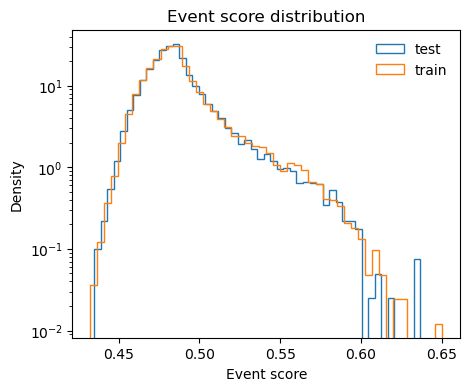

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.hist(y_prob_test, bins=50, histtype='step', density=True, label='test')
ax.hist(y_prob_train, bins=50, histtype='step', density=True, label='train')

ax.set_title('Event score distribution')
ax.set_xlabel('Event score')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend(frameon=False)

plt.show()

In [8]:
background_efficiencies = np.logspace(-4, -0.5, 100)

train_SR_S_pass, train_SR_B_pass, test_SR_B_pass = [], [], []
for eff_test in background_efficiencies:
    threshold = utils.get_threshold_from_fpr(fpr, thresholds, eff_test)

    y_prob_train_S = y_prob_train[y_train_SR == 1]
    y_prob_train_B = y_prob_train[y_train_SR == 0]

    sig_pass = (y_prob_train_S > threshold).sum() / len(y_prob_train_S) * n_SR_S if n_SR_S > 0 else 0
    bkg_pass = (y_prob_train_B > threshold).sum() / len(y_prob_train_B) * n_SR_B if n_SR_B > 0 else 0
    train_SR_S_pass.append(sig_pass)
    train_SR_B_pass.append(bkg_pass)

    test_bkg_pass = (y_prob_test > threshold).sum() / len(y_prob_test) * n_SR_B
    test_SR_B_pass.append(test_bkg_pass)

train_SR_S_pass = np.array(train_SR_S_pass)
train_SR_B_pass = np.array(train_SR_B_pass)
test_SR_B_pass = np.array(test_SR_B_pass)

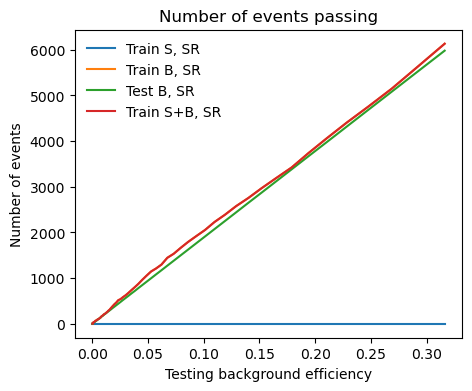

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.plot(background_efficiencies, train_SR_S_pass, label='Train S, SR')
ax.plot(background_efficiencies, train_SR_B_pass, label='Train B, SR')
ax.plot(background_efficiencies, test_SR_B_pass, label='Test B, SR')
ax.plot(background_efficiencies, train_SR_S_pass + train_SR_B_pass, label='Train S+B, SR')

ax.set_title('Number of events passing')
ax.set_xlabel('Testing background efficiency')
ax.set_ylabel('Number of events')
# ax.set_xscale('log')
ax.legend(frameon=False)

plt.show()

/tmp/ipykernel_1173964/2008157992.py:3: RuntimeWarning: divide by zero encountered in divide
  ax.plot(background_efficiencies, train_SR_B_pass / test_SR_B_pass, label='Train B / Test B')


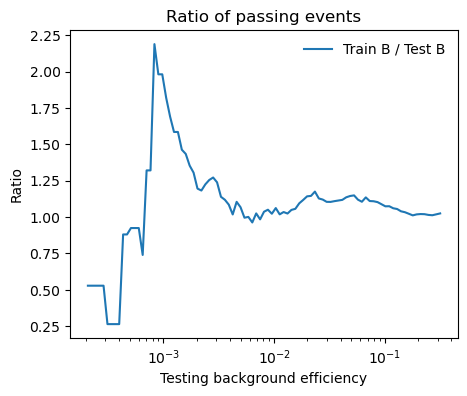

In [10]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.plot(background_efficiencies, train_SR_B_pass / test_SR_B_pass, label='Train B / Test B')

ax.set_title('Ratio of passing events')
ax.set_xlabel('Testing background efficiency')
ax.set_ylabel('Ratio')
ax.set_xscale('log')
ax.legend(frameon=False)

plt.show()

/tmp/ipykernel_1173964/2495667409.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(2 * (S + B) * np.log(1 + S/B) - 2 * S)
/tmp/ipykernel_1173964/3450920375.py:5: RuntimeWarning: divide by zero encountered in divide
  ax.plot(background_efficiencies, train_SR_B_pass / test_SR_B_pass, label='Train B / Test B')


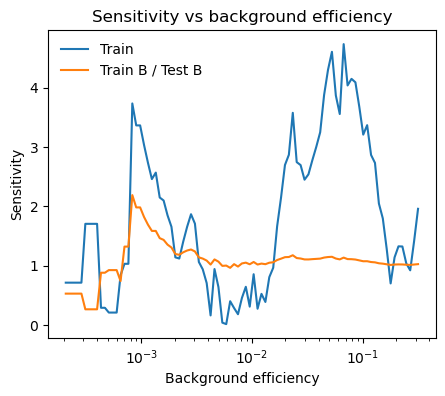

In [11]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
nS = train_SR_S_pass + train_SR_B_pass - test_SR_B_pass
nB = test_SR_B_pass
ax.plot(background_efficiencies, realistic_sensitivity(nS, nB), label='Train')
ax.plot(background_efficiencies, train_SR_B_pass / test_SR_B_pass, label='Train B / Test B')

ax.set_title('Sensitivity vs background efficiency')
ax.set_xlabel('Background efficiency')
ax.set_ylabel('Sensitivity')
ax.set_xscale('log')
ax.legend(frameon=False)

plt.show()